# Post training a VLM for reasoning with GRPO using TRL

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **WARNING**: This notebook is resource-intensive and requires substantial computational power. If you're running this in Colab, it will utilize an A100 GPU.

In this recipe, we'll demonstrate how to post-train a [Vision Language Model (VLM)](https://huggingface.co/blog/vlms-2025) using [GRPO](https://huggingface.co/docs/trl/grpo_trainer) for adding reasoning capabilities to a VLM using the Hugging Face ecosystem, specifically with the [Transformer Reinforcement Learning library (trl)](https://huggingface.co/docs/trl/index).


We'll be fine-tuning [Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct) using a subset of the [lmms-lab/multimodal-open-r1-8k-verified](https://huggingface.co/datasets/lmms-lab/multimodal-open-r1-8k-verified) dataset. This dataset includes images with problem descriptions along with their solution and thinking trace to reach that solution. We'll leverage this data format, along with the GRPO reward functions, to teach the model how to reason to reach the solution.

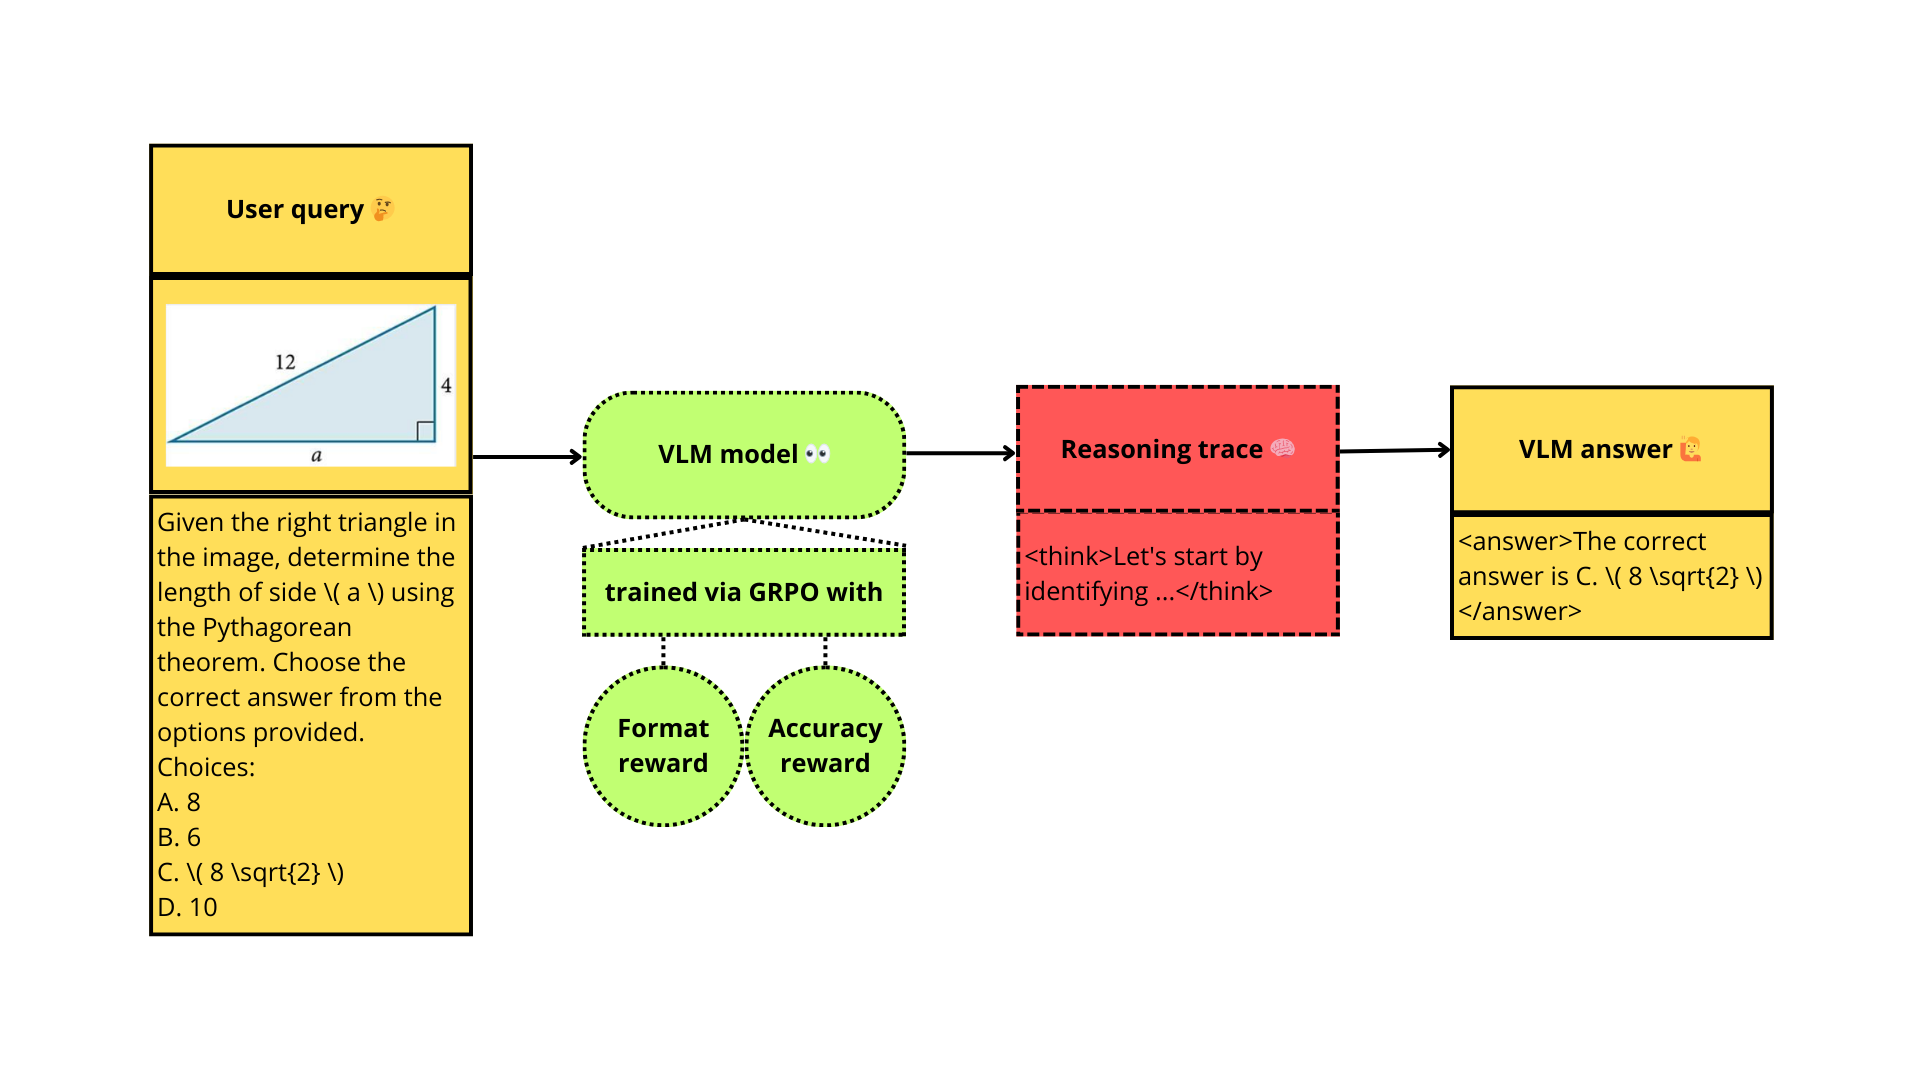

## 1. Install Dependencies

Let's start by installing the essential libraries we'll need for fine-tuning.
We'll install `trl` from source, as the VLM GRPO trainer hasn't been included in an official release at the time of writing.


In [ ]:
!pip install -U -q git+https://github.com/huggingface/trl.git peft math_verify qwen-vl-utils[decord]

Authenticate using your Hugging Face 🤗 account to save and share the trained model.

In [ ]:
from huggingface_hub import login

login()

## 2. Load Dataset 📁

We leverage [lmms-lab/multimodal-open-r1-8k-verified](https://huggingface.co/datasets/lmms-lab/multimodal-open-r1-8k-verified) for this recipe. This dataset contains 8k multimodal RL training examples focused on math reasoning. This data was created using GPT4o and includes `image`, `problem`, `solution`, `original question` and `original answer` for each sample. It was created in [this project](https://github.com/EvolvingLMMs-Lab/open-r1-multimodal).

For our particular case where we want the model to learn to reason using images, we use `image` and  `problem` as input and `solution` as output.

For this educational resource, we'll only use 5% of the dataset and divide it into train and test sets to make it faster to train. In a real training, we'd use the full dataset.

We'll load the dataset and divide it.

In [ ]:
from datasets import load_dataset

dataset_id = 'lmms-lab/multimodal-open-r1-8k-verified'
dataset = load_dataset(dataset_id, split='train[:5%]')

split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

Let's check the structure of the dataset.

In [ ]:
print(train_dataset)

Dataset({
    features: ['image', 'problem', 'solution', 'original_question', 'original_answer'],
    num_rows: 307
})


Let's check one sample:

In [ ]:
print(train_dataset[0])

In addition to the `problem` and `image` columns, we also include a custom system prompt to tell the model how we'd like the generation.

The system prompt is extracted from DeepSeek R1. Refer to [this previous recipe](https://huggingface.co/learn/cookbook/fine_tuning_llm_grpo_trl) for more details.

We convert the dataset samples into conversation samples, including the system prompt and one image and problem description per sample, since this is how the GRPO trainer expects them.

We also set `padding_side="left"` to ensure that generated completions during training are concatenated directly after the prompt, which is essential for GRPO to correctly compare token-level probabilities between preferred and rejected responses.

In [ ]:
from transformers import AutoProcessor

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
processor = AutoProcessor.from_pretrained(model_id, use_fast=True, padding_side="left")

SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)

def make_conversation(example):
    conversation = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["problem"]},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
    }

train_dataset = train_dataset.map(make_conversation)

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Let's take a look at a converted example:

In [ ]:
print(train_dataset[0]['prompt'])

<|im_start|>system
A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer><|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Based on the image, determine the constant term after combining all the polynomial expressions representing the side lengths of the triangle. Choose the correct answer from the options provided.

Choices:
A. 3
B. 5
C. 8
D. 13<|im_end|>
<|im_start|>assistant



We'll remove the the columns that we don't need for training.

In [ ]:
train_dataset

Dataset({
    features: ['image', 'problem', 'solution', 'original_question', 'original_answer', 'prompt'],
    num_rows: 307
})

We can check that the columns are now gone.

In [ ]:
train_dataset = train_dataset.remove_columns(['problem', 'original_question', 'original_answer'])
print(train_dataset)

Dataset({
    features: ['image', 'solution', 'prompt'],
    num_rows: 307
})


## 3. Post-Training the VLM Using GRPO

The diagram below highlights the main differences between **PPO** (Proximal Policy Optimization) and **GRPO** (Group Relative Policy Optimization), specifically the removal of the value model in GRPO. For more detailed information on the key differences, you can refer to this [further explanation](https://www.philschmid.de/deepseek-r1).

To implement the training pipeline, we leverage trl, Hugging Face's library for reinforcement learning, which provides a streamlined interface and built-in support for key training algorithms. In our case, we use the `GRPOConfig` and `GRPOTrainer` classes. A crucial step in this process is defining custom reward functions that guide the model's behavior and help it align with our specific objectives.

But first, let's load the model. In this case, we use [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen/Qwen2.5-VL-3B-Instruct), a powerful VLM developed by [Qwen](https://huggingface.co/Qwen). For better results, it would be important to consider models with a larger number of parameters.

Others examples of VLM projects that include reasoning capabilities are:


* [GLM-4.1V-9B-Thinking](https://huggingface.co/THUDM/GLM-4.1V-9B-Thinking)

* [VLM-R1 models](https://huggingface.co/collections/omlab/vlm-r1-models-67b7352db15c19d57157c348)

* [R1-V](https://github.com/StarsfieldAI/R1-V)

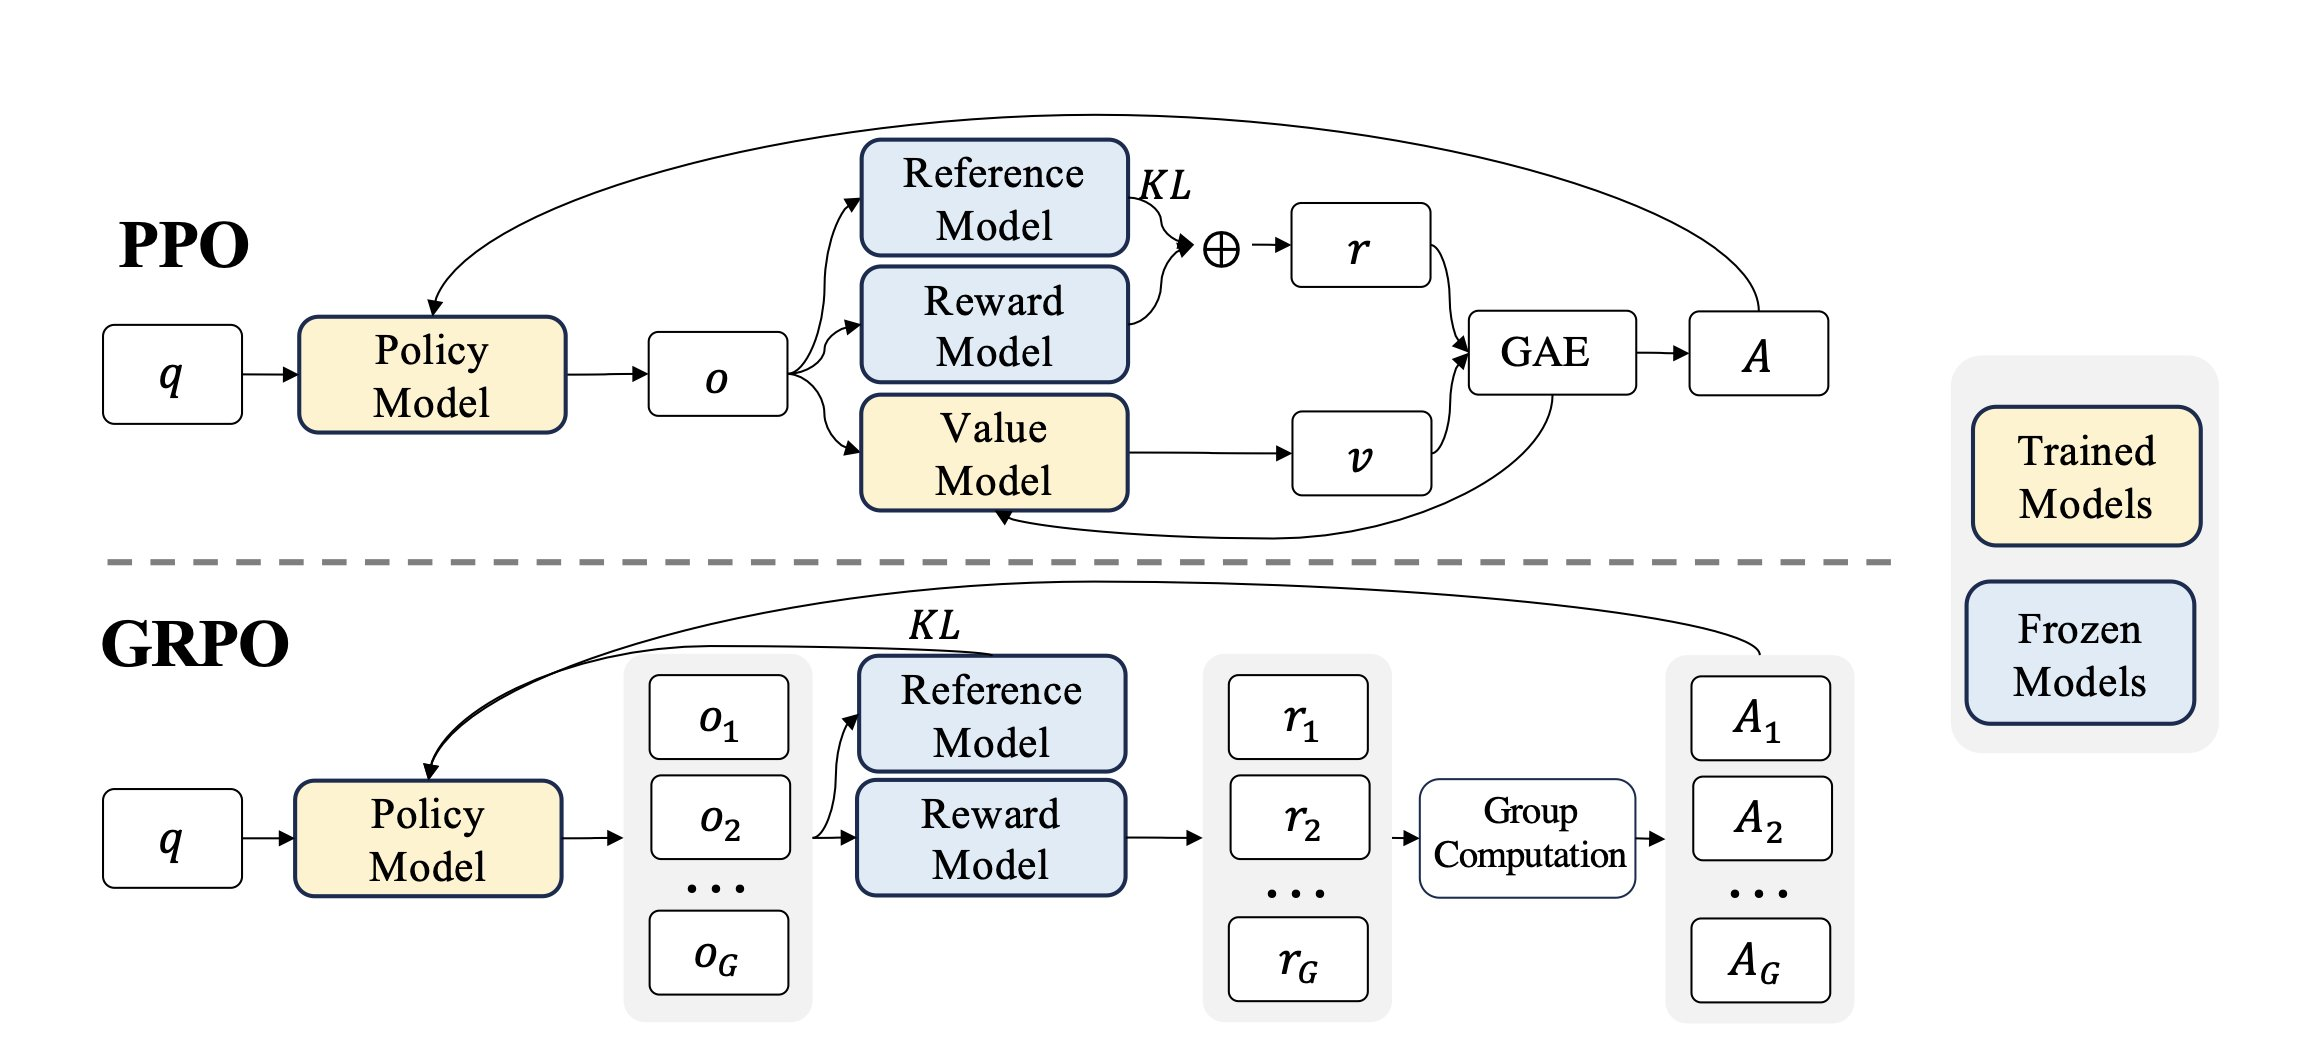

### 3.1 Loading the Baseline Model

Let's load the baseline model first. As previously introduced, `Qwen/Qwen2.5-VL-3B-Instruct`.


In [ ]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3.2 Configuring LoRA

We'll leverage LoRA for training the model, so let's configure it.


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


### 3.3 Loading Reward Functions



For the reward component of the system, we can use either pretrained reward models or reward functions defined directly in code. For training, the DeepSeek-R1 authors used an accuracy-based reward model that evaluates whether the response is correct, alongside a format-based reward that ensures the model places its reasoning process between `<think> </think>` tags. You can find more details [here](https://github.com/huggingface/open-r1/blob/main/src/open_r1/rewards.py). We can simply define and implement these reward functions as generic Python functions.

In this case, we will utilize the following reward functions, directly extracted from the Open R1 [implementation](https://github.com/huggingface/open-r1/blob/main/src/open_r1/rewards.py):

1. **Format Enforcement:** Ensures that the generation follows a specific format using `<think> </think> <answer> </answer>` tags for reasoning.  

In [ ]:
import re
def format_reward(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>\n.*?\n</think>\n<answer>\n.*?\n</answer>$"
    matches = [re.match(pattern, content, re.DOTALL | re.MULTILINE) for content in completions]
    rewards = [1.0 if match else 0.0 for match in matches]
    return rewards

2. **Solution Accuracy:** Verifies whether the solution to the problem is correct, comparing it to the `solution` column in the dataset.

In [ ]:
from math_verify import LatexExtractionConfig, parse, verify
from latex2sympy2_extended import NormalizationConfig
from typing import Optional

def accuracy_reward(completions: list[list[dict[str, str]]], solution: list[str], **kwargs) -> list[Optional[float]]:
    """Reward function that checks if the completion matches the ground truth.
    - If both gold and prediction are parseable → use math verification.
    - If not parseable → compare as normalized text.
    """
    rewards = []

    for completion, sol in zip(completions, solution):
        try:
            gold_parsed = parse(sol, extraction_mode="first_match")
        except Exception as e:
            gold_parsed = []

        if len(gold_parsed) != 0:
            # Try parsing predicted answer too
            try:
                answer_parsed = parse(
                    completion,
                    extraction_config=[
                        LatexExtractionConfig(
                            normalization_config=NormalizationConfig(
                                nits=False,
                                malformed_operators=False,
                                basic_latex=True,
                                boxed="all",
                                units=True,
                            ),
                            boxed_match_priority=0,
                            try_extract_without_anchor=False,
                        )
                    ],
                    extraction_mode="first_match",
                )
                reward = float(verify(gold_parsed, answer_parsed))
            except Exception as e:
                print(f"verify failed: {e}, answer: {completion}, gold: {sol}")
                reward = None
        else:
            # fallback to text match
            reward = float(completion.strip().lower() == sol.strip().lower())

        rewards.append(reward)

    return rewards

### 3.4 Configuring GRPO Training Parameters

Next, let's configure the training parameters for GRPO. We recommend experimenting with the `max_completion_length`, `num_generations`, and `max_prompt_length` parameters.

It'd be interesting to play with the `max_completion_length`, `num_generations`, and `max_prompt_length` params in order to find the best training combination.

The parameter selection has been adjusted to fit within the hardware limitations of a Google Colab session. To observe the full potential of reward improvements, especially in the second objective function, and to further improve the model's reasoning capabilities in a real-world scenario, a more ambitious setup would be required. This would involve larger models, an increased number of generations, and a high-quality, diverse dataset.

In [ ]:
from trl import GRPOConfig

# Configure training arguments using GRPOConfig
training_args = GRPOConfig(
    output_dir="Qwen2.5-VL-3B-Instruct-Thinking",
    learning_rate=1e-5,
    remove_unused_columns=False, # to access the solution column in accuracy_reward
    num_train_epochs=1,
    bf16=True,

    # Parameters that control the data preprocessing
    per_device_train_batch_size=2,
    max_completion_length=1024, # default: 256
    num_generations=2, # default: 8
    max_prompt_length=2048,

    # Parameters related to reporting and saving
    report_to=["tensorboard"],
    logging_steps=10,
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
)

### 3.5 Training the Model 🏃

Now, let's configure the trainer and start training the model!

In this case, we pass the two reward functions we previously defined to the trainer, in addition with the model, trainings arguments and dataset.

Below, you'll find a diagram of the training procedure we'll be reproducing, which is extracted from the [Open-R1 project](https://github.com/huggingface/open-r1).

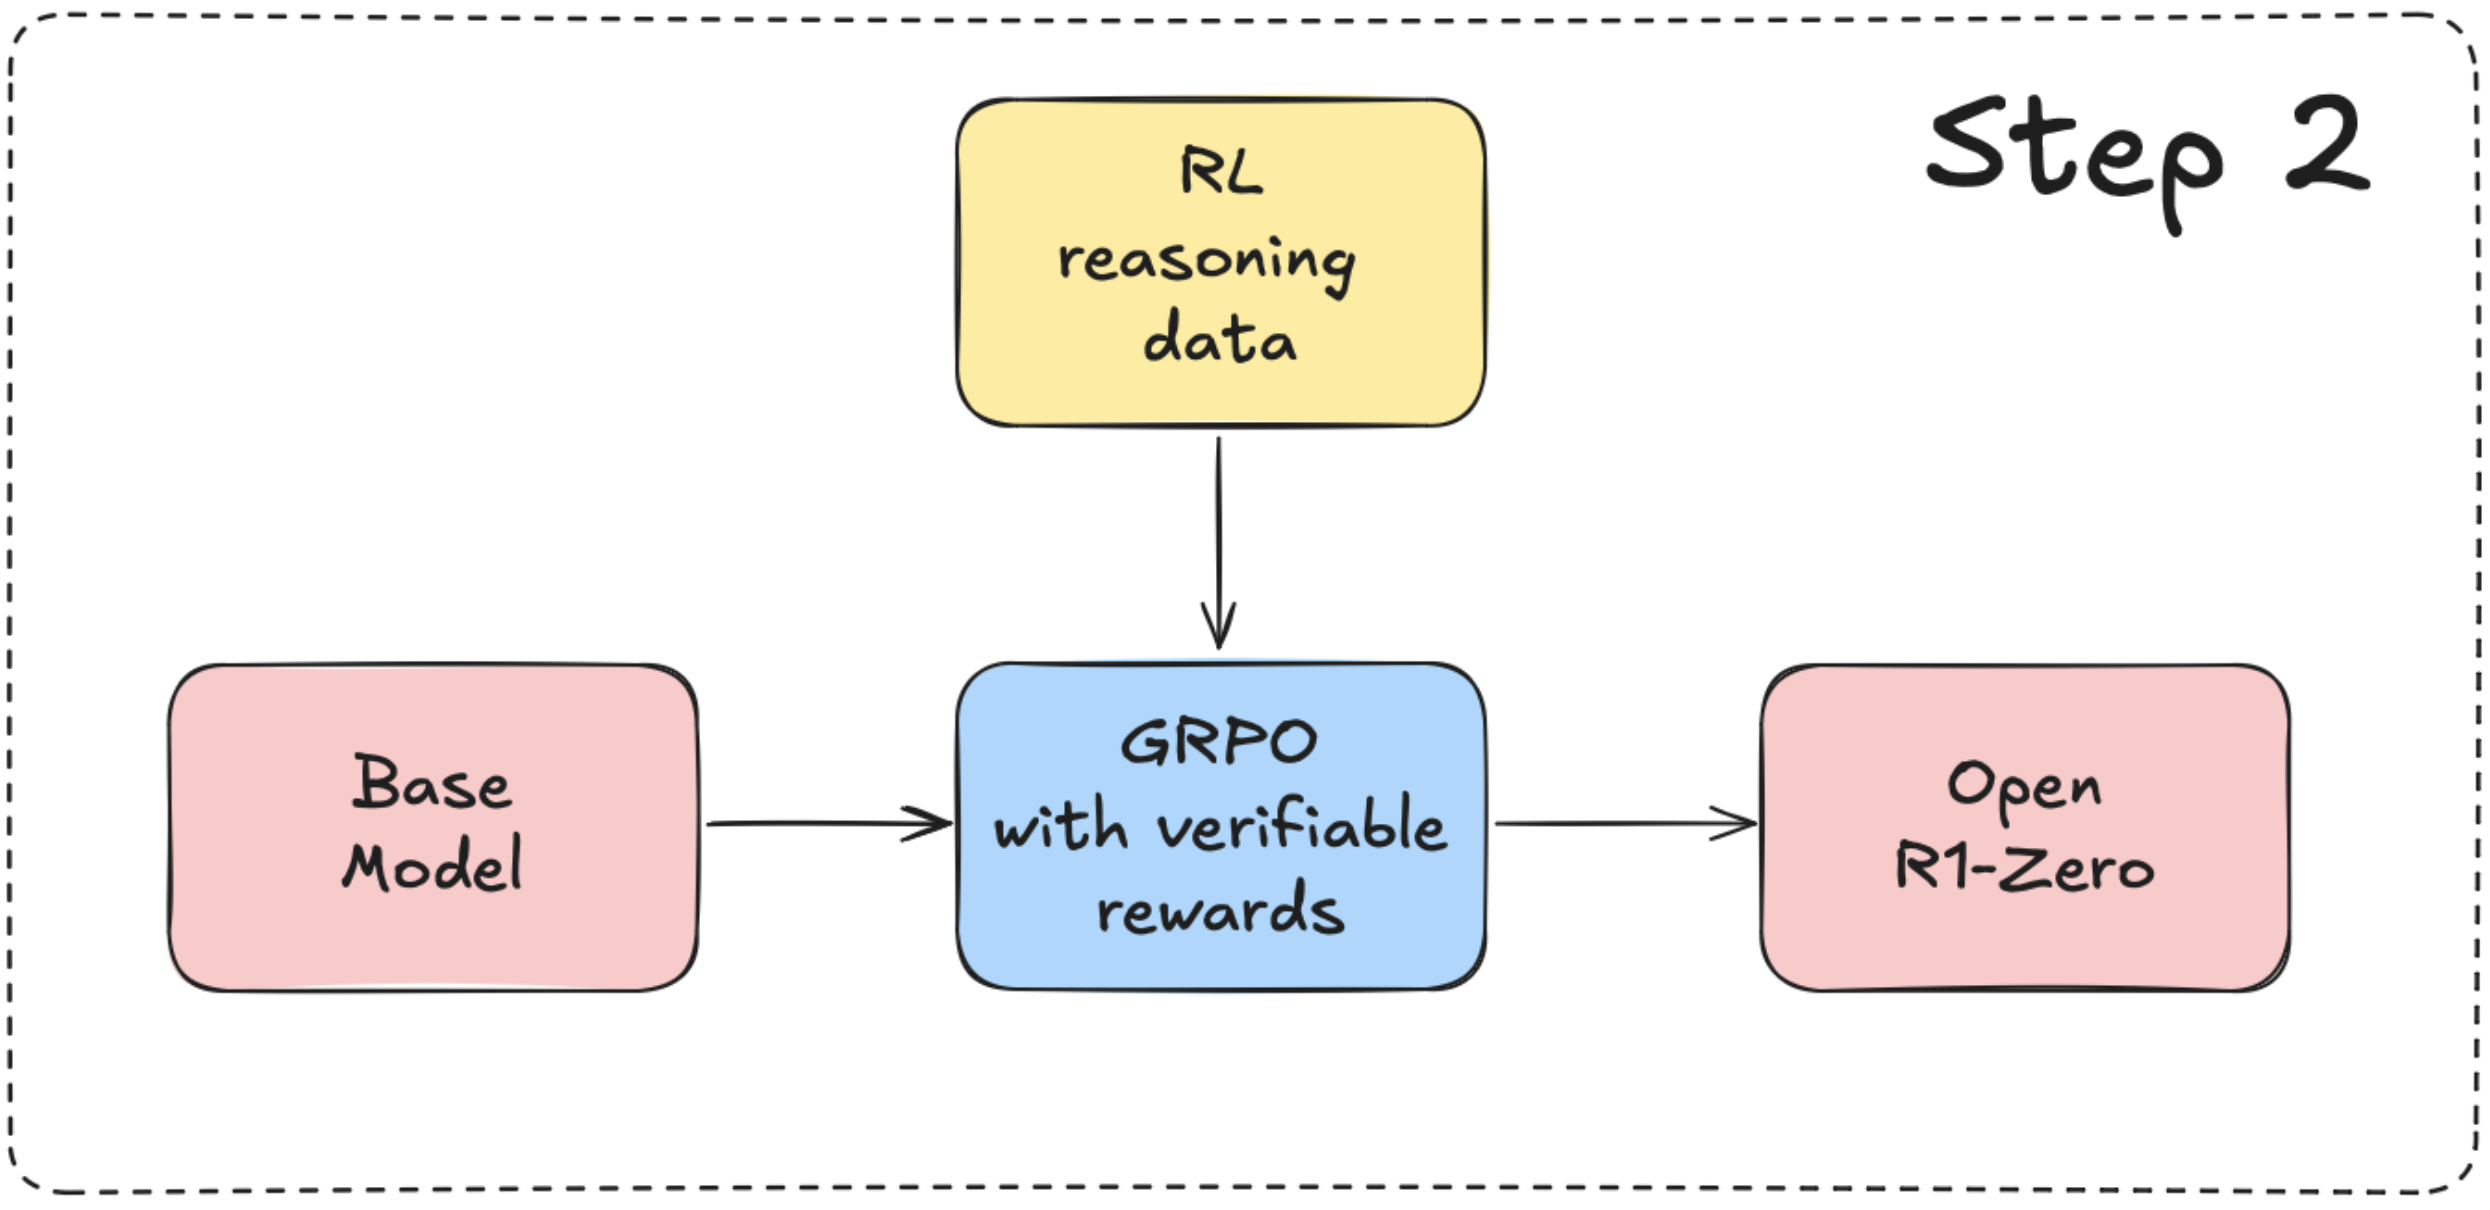

In [ ]:
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[format_reward, accuracy_reward],
    args=training_args,
    train_dataset=train_dataset,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Time to train the model!

In [ ]:
trainer.train()

Step,Training Loss
10,0.012900
20,0.000000
30,-0.039200
40,0.003400
50,-0.056600
60,-0.036600
70,0.025500
80,-0.006600
90,0.100600
100,-0.002800


TrainOutput(global_step=307, training_loss=-0.00434079780228169, metrics={'train_runtime': 6637.1415, 'train_samples_per_second': 0.046, 'train_steps_per_second': 0.046, 'total_flos': 0.0, 'train_loss': -0.00434079780228169})

We can review the training metrics directly in TensorBoard on the [model page]((https://huggingface.co/sergiopaniego/Qwen2.5-VL-3B-Instruct-Thinking/tensorboard). While the loss curve might look a bit off, the reward results tell a clearer story: the model steadily improves, increasing the amount of reward it receives over time.

Now, let's save the results in our account 💾

In [ ]:
trainer.save_model(training_args.output_dir)
trainer.push_to_hub(dataset_name=dataset_id)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sergiopaniego/Qwen2.5-VL-3B-Instruct-Thinking/commit/6bd4e48f478b06e3f5d06bb03c7280eca7ec48f5', commit_message='End of training', commit_description='', oid='6bd4e48f478b06e3f5d06bb03c7280eca7ec48f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergiopaniego/Qwen2.5-VL-3B-Instruct-Thinking', endpoint='https://huggingface.co', repo_type='model', repo_id='sergiopaniego/Qwen2.5-VL-3B-Instruct-Thinking'), pr_revision=None, pr_num=None)

## 4. Check the Model Performance

Now that we've our model trained, we can check it's performance to evaluate it qualitatively.

> We recommend restarting your session in order to free the resources used for training.

In [ ]:
trained_model_id = "sergiopaniego/Qwen2.5-VL-3B-Instruct-Thinking"

For that, we will be using the test subset of our dataset. Let's first load our trained model and it's processor.

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

trained_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    trained_model_id,
    torch_dtype="auto",
    device_map="auto",
)
trained_processor = AutoProcessor.from_pretrained(trained_model_id, use_fast=True, padding_side="left")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/7.39M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

We'll generate an auxiliary function for generating our responses. This will make it easier for us to just send a problem and image and retrieve the model response, which should include the reasoning trace and final answer.

In [ ]:
import time
import torch
from qwen_vl_utils import process_vision_info


def generate_with_reasoning(problem, image):
    # Conversation setting for sending to the model
    conversation = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": problem},
            ],
        },
    ]
    prompt = trained_processor.apply_chat_template(
      conversation,
      add_generation_prompt=True,
      tokenize=False
    )

    # Process images using the process_vision_info from qwen_vl_utils
    image_inputs, video_inputs = process_vision_info(conversation)

    inputs = processor(
        text=[prompt],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(trained_model.device)

    # Generate text without gradients
    start_time = time.time()
    with torch.no_grad():
        output_ids = trained_model.generate(**inputs, max_new_tokens=500)
    end_time = time.time()

    # Decode and extract model response
    generated_text = trained_processor.decode(output_ids[0], skip_special_tokens=True)

    # Get inference time
    inference_duration = end_time - start_time

    # Get number of generated tokens
    num_input_tokens = inputs["input_ids"].shape[1]
    num_generated_tokens = output_ids.shape[1] - num_input_tokens

    return generated_text, inference_duration, num_generated_tokens

Let's check it!

In [ ]:
generated_text, inference_duration, num_generated_tokens = generate_with_reasoning(test_dataset[0]['problem'], test_dataset[0]['image'])
print(generated_text)

system
A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>
user
Based on the image, determine the sine value of angle AOB if it measures 120 degrees. Choose the correct answer from the options provided.

Choices:
A. $\frac{\sqrt{3}}{2}$
B. $\frac{1}{2}$
C. $-\frac{\sqrt{3}}{2}$
D. $\sqrt{2}$
assistant
<think>
In a circle, the sine of an angle is equal to the ratio of the length of the side opposite the angle to the hypotenuse. In this case, since angle AOB is 120 degrees, we can use the properties of a 30-60-90 triangle to find the sine value. The sine of 120 degrees is equivalent to the sine of 60 degrees because 180 - 120 = 60. The sine of 60 d

The answer seems to follow the constraints that we've added during traing using the reward functions. We can sse that the model generates something like this: `<think>reasoning</think><answer>solution</answer>`. Let's check the actual solution, to understand if the model is correct.

In [ ]:
test_dataset[0]['solution']

'<think>Let me think about this. The angle AOB is given as 120 degrees. To find the sine of this angle, I can use the unit circle or trigonometric identities. In the unit circle, the sine of an angle is the y-coordinate of the corresponding point. For 120 degrees, which is in the second quadrant, the reference angle is 180 - 120 = 60 degrees. The sine of 60 degrees is $\\frac{\\sqrt{3}}{2}$. Since sine is positive in the second quadrant, the sine of 120 degrees is also $\\frac{\\sqrt{3}}{2}$. Therefore, the correct answer is A.</think>\n\n<answer>A</answer>'

It seems like the model has already including some reasoning capabilities to their functionality! Let's also check the inference time and generated tokens, for further check on the model capabilities.

In [ ]:
print(f"Inference time: {inference_duration:.2f} seconds")
print(f"Generated tokens: {num_generated_tokens}")

Inference time: 11.03 seconds
Generated tokens: 163


## 5. Continuing Your Learning Journey 🧑‍🎓

The learning journey does not stop here!

If you're eager on discovering more about GRPO, reasoning or VLMs, we can recommend some materials:

* [`Post training an LLM for reasoning with GRPO in TRL` recipe and the linked resources that it includes](https://huggingface.co/learn/cookbook/fine_tuning_llm_grpo_trl)
* [GLM-4.1V-9B-Thinking paper](https://huggingface.co/papers/2507.01006)
* [TRL GRPO for VLMs example](https://github.com/huggingface/trl/examples/scripts/grpo_vlm.py)